In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
print(tf.test.is_gpu_available())

import matplotlib.pyplot as plt
import numpy as np

2.0.0
True


In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2

# config

In [2]:
data_path = '/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/melspectrograms/melspectrograms'
train_path = data_path + '/train/*/*'
test_path = data_path + '/test/*/*'
val_path = data_path + '/validation/*/*'

class_names = ['sick', 'not_sick']
img_height = 480#227
img_width = 640#227
batch_size = 4
train_samples = 1434 + 2282
steps_per_epoch = train_samples // batch_size
steps_per_epoch

929

# get dataset

In [3]:
def decode_str_tensor(tensor):
    return bytes.decode(tensor.numpy())

def stats(t):
    s = 'mean:'
    s += str(t.mean())
    s += ' max:'
    s += str(t.max())
    s += ' min:'
    s += str(t.min())
    s += ' median:'
    s += str(np.median(t))
    s += ' std:'
    s += str(t.std())
    s += ' shape:'
    s += str(t.shape)
    s += ' dtype:'
    s += str(t.dtype)
    print(s)

In [4]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    one_hot = tf.cast(one_hot, tf.int64)
    # Integer encode the label
    return tf.argmax(one_hot)
# get_label('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform/train/sick/audioset_0CroKP1sYVw_10_15.jpg')

In [5]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    # resize the image to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    return img, label
# img, label = process_path('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform/train/sick/audioset_0CroKP1sYVw_10_15.jpg')
# stats(img.numpy())

In [6]:
def get_dataset(path, name):
    ds = tf.data.Dataset.list_files(path)
    ds = ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache(name).shuffle(buffer_size=100).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = get_dataset(train_path, 'train_catch')
test_ds = get_dataset(test_path, 'test_catch')
val_ds = get_dataset(val_path, 'val_catch')
train_ds

<DatasetV1Adapter shapes: ((None, 480, 640, 3), (None,)), types: (tf.float32, tf.int64)>

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (4, 480, 640, 3)
Label:  [1 0 1 0]


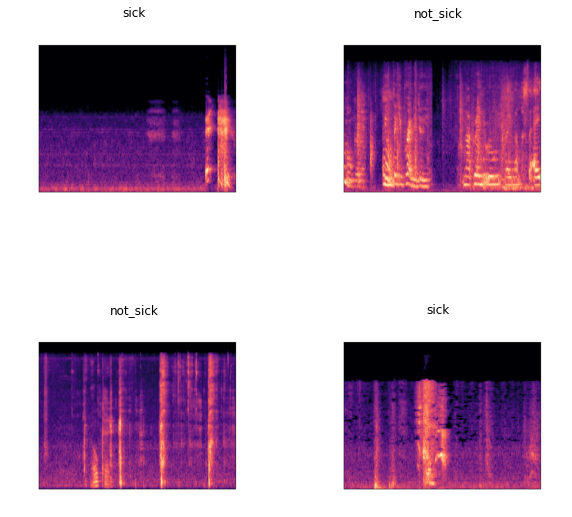

In [8]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow((image_batch[i].numpy()).astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# model

### Feature extraction

In [9]:
IMG_SHAPE = (img_height, img_width, 3)
# base_model = tf.keras.applications.DenseNet121(include_top=False, 
#                                                weights='imagenet', 
#                                                input_shape=IMG_SHAPE
# )
base_model = tf.keras.applications.ResNet50(include_top=False, 
                                            weights='imagenet', 
                                            input_shape=IMG_SHAPE,
                                            classes=1)
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 646, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 240, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 240, 320, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 480, 640, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 15, 20, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [11]:
base_learning_rate = 0.0001
save_dir = './fine_tune_resnet50_mel/'
log_dir = save_dir + 'logs/'
checkpoint_dir = save_dir + 'checkpoint_Feature_extraction/'

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    base_learning_rate,
    decay_steps=steps_per_epoch*5,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(lr_schedule)

callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.TensorBoard(log_dir),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                            monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                            save_weights_only=True)
    ]

In [12]:
initial_epochs = 100

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# history = model.fit(train_ds,
#                     epochs=initial_epochs,
#                     validation_data=val_ds,
#                     callbacks=callbacks)

In [13]:
model.load_weights(checkpoint_dir)
model.evaluate(test_ds)

413/413 [==============================] - 67s 161ms/step - loss: 0.4691 - accuracy: 0.7748


[0.469092186639586, 0.7748184]

### fine tuning

In [14]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable =  False

Number of layers in the base model:  175


In [15]:
fine_tune_epochs = 100 + initial_epochs

checkpoint_dir = save_dir + 'checkpoint_fine-tuning_bigger_lr/'
callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
        tf.keras.callbacks.TensorBoard(log_dir),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                            monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                            save_weights_only=True)
    ]
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    base_learning_rate/3,
    decay_steps=steps_per_epoch*5,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = optimizer,
              metrics=['accuracy'])
model.summary()
history_fine = model.fit(train_ds,
                         epochs=fine_tune_epochs,
#                          initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=callbacks)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 480, 640, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 15, 20, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [16]:
model.load_weights(checkpoint_dir)
model.evaluate(test_ds)

413/413 [==============================] - 62s 151ms/step - loss: 0.6817 - accuracy: 0.8904


[0.6816718862651335, 0.8904358]